# Projet 5 : Catégorisez automatiquement des questions

L'objectif de ce projet est d'appliquer des tags à des questions issues du site stackoverflow. Pour cela on va utiliser l'outil StackExchange qui permet de lancer des requêtes SQL sur la base de données de stackoverflow.

## Notebook 1 : Exploration
* Extraction des données

## Ressources intéressantes

MODELS : https://scikit-learn.org/stable/modules/classes.html#module-sklearn.multioutput
METRICS : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.zero_one_loss.html#sklearn.metrics.zero_one_loss

LDA evaluation on sklearn and explanations https://github.com/derekgreene/topic-model-tutorial
LDA : https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
LDA Evaluatio : https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
sklearn lda and nmf : https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
topic model with gensim : https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
Try LSA (first you need to do TF-IDF) : https://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/
complet lda with gensim choosing best k for Nbr topics : https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
automatic choice of K using HDP : https://datascience.stackexchange.com/questions/128/latent-dirichlet-allocation-vs-hierarchical-dirichlet-process

lda vs lsa vs plsa vs lda2vec : https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05
LDA evaluation : https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

count vectorizer : 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

utiliser sklearn.feature_extraction.text.CountVectorizer

### Stratification

http://videolectures.net/ecmlpkdd2011_tsoumakas_stratification/?q=stratification%20multi%20label

http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html

## Librairies  utilisées

In [1]:
import pandas as pd
import numpy as np

# text preprocessing
import nltk
from bs4 import BeautifulSoup
import spacy

# gensim
import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora

# plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim

# sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV

nlp = spacy.load("en_core_web_sm")
#nltk.download()
n_jobs = -1 # enable multiprocessing

## Extraction des données

On peut lancer des requêtes SQL grâce à l'outil StackExchanger : https://data.stackexchange.com/stackoverflow/query/new

Les données ont été extraites avec la requête SQL suivante :


SELECT 
       Posts.Tags as Tags,
       Posts.Title as Title,
       Posts.Body as Body

FROM Posts

WHERE Posts.CreationDate < '2020-01-01' and Posts.CreationDate > '2010-01-01'
      and Posts.Score > 100 and LEN(Posts.Tags) > 0

## Chargement des données

In [2]:
df = pd.read_csv('data/QueryResults1.csv')

In [3]:
df = df.drop_duplicates()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32049 entries, 0 to 32048
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tags    32049 non-null  object
 1   Title   32049 non-null  object
 2   Body    32049 non-null  object
dtypes: object(3)
memory usage: 1001.5+ KB


In [5]:
df.head()

,Tags,Title,Body
0,<node.js><npm>,Easy way to list node modules I have npm linked?,<p>I am looking for a command that will list t...
1,<python><pandas>,Appending to an empty DataFrame in Pandas?,<p>Is it possible to append to an empty data f...
2,<html><xhtml>,Why can't the <p> tag contain a <div> tag insi...,"<p>As far as I know, this is right:</p>\n\n<pr..."
3,<android><view>,Android - get children inside a View?,<p>Given a View how can I get the child views ...
4,<ios><arrays><swift>,Array extension to remove object by value,<pre><code>extension Array {\n func removeO...


<AxesSubplot:ylabel='Tags'>

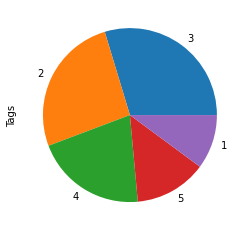

In [6]:
df['Tags'] = df['Tags'].apply(lambda x: x[1:-1].split('><'))
df['Tags'].apply(lambda x: len(x)).value_counts().plot.pie()

<AxesSubplot:>

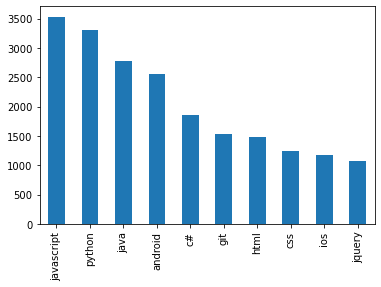

In [7]:
df_test = pd.DataFrame()
df_test['Tags'] = [x for l in df['Tags'].to_list() for x in l]
df_test['Tags'].value_counts().head(10).plot.bar()

Python: NLTK part 1/3 | Natural Language Tool Kit - corpus, punctuation, stop words : https://www.youtube.com/watch?v=gRk53jBPYvE

Python: NLTK part 2/3 | Natural Language Tool Kit - stemmer, tokenizer, POS tagger : https://www.youtube.com/watch?v=RYgqWufzbA8

Python: NLTK part 3/3 | Natural Language Tool Kit - word2vec, clustering, classifying : https://www.youtube.com/watch?v=rJmmh7kiNuQ

## Tag a supprimer

Le format des posts correspond à du code html. C'est donc du texte avec des balises. On peut donc s'intéresser à l'utilité de toutes les balises que l'on peut rencontrer. Voici un exemple de post :

In [8]:
df['Body'][0]

"<p>I am looking for a command that will list the names of global modules that I have <code>npm link</code>'d to local copies, also listing the local path.</p>\n\n<p>In fact, a list of <strong>all</strong> globally installed modules would be even better, with the <code>npm link</code>'d ones <strong>flagged</strong> somehow.</p>\n"

Il faut maintenant déterminer les balises que l'on peut rencontrer. Pour cela on va parcourir l'ensemble des posts afin de déterminer les différentes balises utilisées.

In [9]:
tag_list = []

for post in df['Body'].to_list():
    soup = BeautifulSoup(post, "html.parser")
    
    for tag in soup.find_all(True):
        if (tag.name not in tag_list):
            tag_list.append(tag.name)
            
print(tag_list)

['p', 'code', 'strong', 'pre', 'a', 'blockquote', 'h1', 'ul', 'li', 'hr', 'em', 'ol', 'div', 'h2', 'img', 'kbd', 'h3', 'br', 'b', 'del', 'sup', 'sub', 'i', 'strike', 's', 'table', 'thead', 'tr', 'th', 'tbody', 'td']


Voici un lien avec des explications sur les balises que l'on utilise en html : https://www.w3schools.com/tags/tag_p.asp

Après avoir étudié l'ensemble des balises retrouvées dans le texte. Voici les balises que l'on va supprimer :
* code : code
* a : liens hypertexte
* img : image
* kbd : commande au clavier
* del : texte à supprimer
* strike : texte à supprimer
* s : texte à supprimer

In [10]:
tag_list = ['code','a','img','kbd','del','strike','s']

On définit ensuite une fonction qui va retirer le contenu des tags inutiles ainsi que les tags pour ne laisser que du texte.

In [11]:
def removeTag(text):
    tag_list = ['code','a','img','kbd','del','strike','s']
    soup = BeautifulSoup(text, "html.parser")

    for tag in tag_list:
        for tagless in soup.find_all(tag):
            tagless.decompose()
            
    # to get lowercase text
    return soup.get_text().lower()

In [12]:
df['Body'][0]

"<p>I am looking for a command that will list the names of global modules that I have <code>npm link</code>'d to local copies, also listing the local path.</p>\n\n<p>In fact, a list of <strong>all</strong> globally installed modules would be even better, with the <code>npm link</code>'d ones <strong>flagged</strong> somehow.</p>\n"

In [13]:
removeTag(df['Body'][0])

"i am looking for a command that will list the names of global modules that i have 'd to local copies, also listing the local path.\nin fact, a list of all globally installed modules would be even better, with the 'd ones flagged somehow.\n"

In [14]:
blop = removeTag(df['Body'][0])

In [15]:
blop

"i am looking for a command that will list the names of global modules that i have 'd to local copies, also listing the local path.\nin fact, a list of all globally installed modules would be even better, with the 'd ones flagged somehow.\n"

In [16]:
blop.split()

['i',
 'am',
 'looking',
 'for',
 'a',
 'command',
 'that',
 'will',
 'list',
 'the',
 'names',
 'of',
 'global',
 'modules',
 'that',
 'i',
 'have',
 "'d",
 'to',
 'local',
 'copies,',
 'also',
 'listing',
 'the',
 'local',
 'path.',
 'in',
 'fact,',
 'a',
 'list',
 'of',
 'all',
 'globally',
 'installed',
 'modules',
 'would',
 'be',
 'even',
 'better,',
 'with',
 'the',
 "'d",
 'ones',
 'flagged',
 'somehow.']

## Ponctuation à supprimer

In [17]:
import re
from string import punctuation

print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [18]:
def removePunctuation(text):
    cleaned = re.sub('\n',r' ',text)
    # It is prefereable to replace punctuation char by white space to avoid creating new words
    translate_table = dict((ord(char), ' ') for char in punctuation)   
    cleaned = cleaned.translate(translate_table)
    cleaned = re.sub(r'\s+', ' ',cleaned)
    
    return cleaned

In [19]:
blop = "I'm looking for a command that will list the names of global modules that I have 'd to local copies, also listing the local path.\nIn fact, a list of all globally installed modules would be even better, with the 'd ones flagged somehow.\n"

In [20]:
blop

"I'm looking for a command that will list the names of global modules that I have 'd to local copies, also listing the local path.\nIn fact, a list of all globally installed modules would be even better, with the 'd ones flagged somehow.\n"

In [21]:
removePunctuation(blop)

'I m looking for a command that will list the names of global modules that I have d to local copies also listing the local path In fact a list of all globally installed modules would be even better with the d ones flagged somehow '

In [22]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
tokenizer.tokenize(removeTag(df['Body'][0]))

['i',
 'am',
 'looking',
 'for',
 'a',
 'command',
 'that',
 'will',
 'list',
 'the',
 'names',
 'of',
 'global',
 'modules',
 'that',
 'i',
 'have',
 'd',
 'to',
 'local',
 'copies',
 'also',
 'listing',
 'the',
 'local',
 'path',
 'in',
 'fact',
 'a',
 'list',
 'of',
 'all',
 'globally',
 'installed',
 'modules',
 'would',
 'be',
 'even',
 'better',
 'with',
 'the',
 'd',
 'ones',
 'flagged',
 'somehow']

Donc r'\w+' :  s'appelle expression régulière on utilise la fonction re.sub

## Stop words à supprimer

In [23]:
from nltk.stem.snowball import SnowballStemmer

sw = nltk.corpus.stopwords.words('english')
sw.extend(['error', 'code', 'program', 'question', 'result'])
stemmer = SnowballStemmer("english")

In [24]:
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [25]:
def removeStopWords(text):
    cleaned = " ".join([w for w in text.split() if w not in sw])
    
    return cleaned

In [26]:
def removeLem(text):
    doc = nlp(text)
    cleaned = " ".join([w.lemma_ for w in doc])
    
    return cleaned

utiliser lemmatisation car garde des mots du dictionnaire

https://www.geeksforgeeks.org/part-speech-tagging-stop-words-using-nltk-python/

In [27]:
def onlyNoun(text):
    postag_list = nltk.pos_tag(text.split())
    # essayer avec verbe et nom a voir dans optimisation
    cleaned = " ".join([postag[0] for postag in postag_list if postag[1] == 'NN'])
    
    return cleaned

si on utilise spacy on dervait filtrer mieux

In [28]:
def onlyNoun(text):
    
    doc = nlp(text) 
    cleaned = " ".join([token.text for token in doc if token.pos_ == 'NOUN'])
    
    return cleaned

In [29]:
test = removePunctuation(blop)
result = onlyNoun(test)

In [30]:
test

'I m looking for a command that will list the names of global modules that I have d to local copies also listing the local path In fact a list of all globally installed modules would be even better with the d ones flagged somehow '

In [31]:
result

'command names modules d copies path fact list modules ones'

In [32]:
def textPreprocessingString(text, allowed_postags=['NOUN']):
    doc = nlp(text)
    cleaned = " ".join([token.lemma_ for token in doc if ((token.pos_ in allowed_postags) and (token.text not in sw))])
    
    return cleaned

In [33]:
def textPreprocessingList(text, allowed_postags=['NOUN']):
    doc = nlp(text)
    cleaned = [token.lemma_ for token in doc if ((token.pos_ in allowed_postags) and (token.text not in sw))]
    
    return cleaned

In [34]:
def make_data_words(sentences):
    data_words = [textPreprocessingList(removePunctuation(removeTag(sentence))) for sentence in sentences]
    
    return data_words
    

In [35]:
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import gensim

In [36]:
data_words = make_data_words(df['Body'].to_list())

In [37]:
data_words

[['command',
  'name',
  'module',
  'copy',
  'path',
  'fact',
  'list',
  'module',
  'one'],
 ['data', 'frame', 'index', 'column', 'dataframe', 'end', 'e', 'g'],
 ['one', 'one', 'tag', 'containment', 'relationship'],
 ['view',
  'child',
  'view',
  'custom',
  'view',
  'debugger',
  'view',
  'way',
  'view',
  'api',
  'suggestion',
  'custom',
  'view'],
 ['method', 'signature', 'anyobject', 'way'],
 ['thing', 'browser', 'notice', 'issue', 'call', 'stack'],
 ['way',
  'javascript',
  'function',
  'parameter',
  'type',
  'answer',
  'date',
  'order',
  'date',
  'function',
  'date',
  'function',
  'variable',
  'type',
  'date'],
 ['mac',
  'file',
  'terminal',
  'type',
  'lot',
  'file',
  'click',
  'file',
  'idea',
  'type',
  'chmod',
  'terminal',
  'change',
  'permission',
  'file',
  'file',
  'automation',
  'way',
  'way',
  'thank'],
 ['subject',
  'pop',
  'stack',
  'overflow',
  'time',
  'time',
  'question',
  'silence',
  'op',
  'rep',
  'information',


In [38]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
# higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [39]:
# Define functions for bigrams, trigrams

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [40]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)


In [41]:
data_words_bigrams

[['command',
  'name',
  'module',
  'copy',
  'path',
  'fact',
  'list',
  'module',
  'one'],
 ['data_frame', 'index', 'column', 'dataframe', 'end', 'e_g'],
 ['one', 'one', 'tag', 'containment', 'relationship'],
 ['view',
  'child',
  'view',
  'custom',
  'view',
  'debugger',
  'view',
  'way',
  'view',
  'api',
  'suggestion',
  'custom',
  'view'],
 ['method', 'signature', 'anyobject', 'way'],
 ['thing', 'browser', 'notice', 'issue', 'call', 'stack'],
 ['way',
  'javascript',
  'function',
  'parameter',
  'type',
  'answer',
  'date',
  'order',
  'date',
  'function',
  'date',
  'function',
  'variable',
  'type',
  'date'],
 ['mac',
  'file',
  'terminal',
  'type',
  'lot',
  'file',
  'click',
  'file',
  'idea',
  'type',
  'chmod',
  'terminal',
  'change',
  'permission',
  'file',
  'file',
  'automation',
  'way',
  'way',
  'thank'],
 ['subject',
  'pop',
  'stack_overflow',
  'time',
  'time',
  'question',
  'silence',
  'op',
  'rep',
  'information',
  'time',
 

In [42]:
df['data_words'] = data_words_bigrams

In [43]:
index_logic = df['data_words'].apply(lambda x: len(x) > 0)
df_data_words = df.loc[index_logic,:]
df_data_words = df_data_words.reset_index(drop=True)

In [44]:
df_data_words.to_csv('df_data_words.csv', sep=';', index=False)

# Apprentissage non suppervisé

## Coherence score

le score est faible si le même mot est important sur plusieurs topic.

very interesting documentation : https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

https://arxiv.org/pdf/1403.6397.pdf

https://stats.stackexchange.com/questions/375062/how-does-topic-coherence-score-in-lda-intuitively-makes-sense

http://qpleple.com/topic-coherence-to-evaluate-topic-models/

### Latent Dirichlet Allocation (LDA)

LDA Part 1 : https://www.youtube.com/watch?v=T05t-SqKArY

LDA Part 2 Gibbs Sampling : https://www.youtube.com/watch?v=BaM1uiCpj_E

In [45]:
data_words = df_data_words['data_words'].to_list()

# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [46]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [47]:
lda_model.print_topics(num_topics=10, num_words=5)

[(0,
  '0.058*"version" + 0.053*"test" + 0.041*"python" + 0.034*"package" + 0.019*"warning"'),
 (1,
  '0.038*"difference" + 0.025*"type" + 0.017*"example" + 0.015*"c" + 0.014*"library"'),
 (2,
  '0.052*"view" + 0.030*"controller" + 0.027*"size" + 0.021*"app" + 0.021*"screen"'),
 (3,
  '0.124*"file" + 0.037*"project" + 0.037*"command" + 0.024*"line" + 0.022*"script"'),
 (4,
  '0.055*"user" + 0.040*"app" + 0.032*"application" + 0.028*"server" + 0.021*"time"'),
 (5,
  '0.066*"git" + 0.062*"branch" + 0.051*"change" + 0.039*"repository" + 0.037*"commit"'),
 (6,
  '0.059*"function" + 0.052*"method" + 0.039*"way" + 0.037*"object" + 0.035*"class"'),
 (7,
  '0.038*"element" + 0.025*"button" + 0.025*"component" + 0.023*"html" + 0.022*"event"'),
 (8,
  '0.047*"datum" + 0.044*"value" + 0.044*"array" + 0.040*"table" + 0.036*"column"'),
 (9,
  '0.043*"page" + 0.041*"image" + 0.038*"string" + 0.035*"request" + 0.027*"browser"')]

In [48]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5402715570443434


#### Visualisation

In [49]:
pyLDAvis.enable_notebook()
vis_lda = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis_lda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.220735 -0.033347       1        1  15.568453
6      0.190925 -0.158527       2        1  13.705620
1      0.040861 -0.131771       3        1  11.627364
4     -0.099243  0.080129       4        1  11.524375
8      0.215193 -0.109201       5        1  10.172568
7      0.112781  0.162409       6        1   8.814022
9      0.056809  0.173715       7        1   8.754643
2      0.006088  0.218593       8        1   7.410786
0     -0.146532 -0.136876       9        1   7.151425
5     -0.156146 -0.065123      10        1   5.270743, topic_info=         Term         Freq        Total Category  logprob  loglift
45       file  9732.000000  9732.000000  Default  30.0000  30.0000
35   function  4162.000000  4162.000000  Default  29.0000  29.0000
251     value  4603.000000  4603.000000  Default  28.0000  28.0000
184      user  3443.000000  3443.000000  Default  27.0000  27.0000
168   version  3106.000000  3106.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
29      issue   209.000010  1711.720135  Topic10  -4.8270   0.8401
16        tag   145.647071   864.223387  Topic10  -5.1882   1.1624
45       file   177.454302  9732.376533  Topic10  -4.9906  -1.0615
77       time   162.625937  3742.712544  Topic10  -5.0779  -0.1931
239      work   148.258084  1684.952920  Topic10  -5.1704   0.5125

[639 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
495       1  0.031185     access
495       3  0.219711     access
495       4  0.596765     access
495       5  0.009922     access
495       6  0.022680     access
...     ...       ...        ...
239      10  0.087836       work
2548      1  0.988097  workspace
433       8  0.997987      xcode
2865      9  0.986974       yaml
4906     10  0.986189        zip

[1414 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 2, 5, 9, 8, 10, 3, 1, 6])

## Optimisation

Parametres à optimiser :

nombre de topic


In [50]:
result_list = []

for nb_topic in [4,6,8,10,12,14,16,18,20]:
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=nb_topic, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    result_list.append(coherence_lda)
    
    

Text(0, 0.5, 'Coherence score')

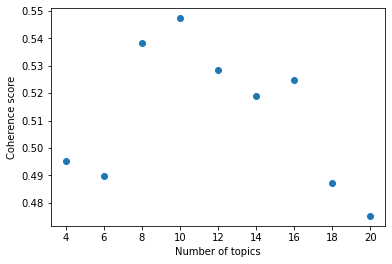

In [51]:
plt.scatter([4,6,8,10,12,14,16,18,20],result_list)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')

### Préparation des données : analyse supervisée

Dans la suite de cette étude on va travailler avec les 100 tags les plus fréquents. Il faut donc : 
* Déterminer les 100 tags les plus fréquents
* Sélectionner les lignes ayant au moins 1 de ces tags
* Supprimer les autres tags.

In [52]:
tag_list = df_data_words['Tags'].to_list()
flat_list = [item for sublist in tag_list for item in sublist]
fdist = nltk.FreqDist(flat_list)
frequent_tags = dict(fdist.most_common(100))
index_logic = df_data_words['Tags'].apply(lambda x: len([tag for tag in x if tag in frequent_tags]) > 0)

In [53]:
df_process = df_data_words.loc[index_logic,:]
df_process.loc[:,'Body_process'] = df_process.loc[:,'Body'].apply(lambda x:textPreprocessingString(removePunctuation(removeTag(x))))
df_process.loc[:,'Tags_process'] = df_process.loc[:,'Tags'].apply(lambda x: [tag for tag in x if tag in frequent_tags])

/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/hugo/anaconda3/envs/projet5/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [54]:
df_process.to_csv('df_process.csv', sep=';', index=False)